<h1 align=center> Facial Expression Recognition with Keras</h1>

### Import Libraries

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

import sys
sys.path.append('../')
import utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

In [5]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.3.1


### Sample Image

ValueError: num must be 1 <= num <= 20, not 21

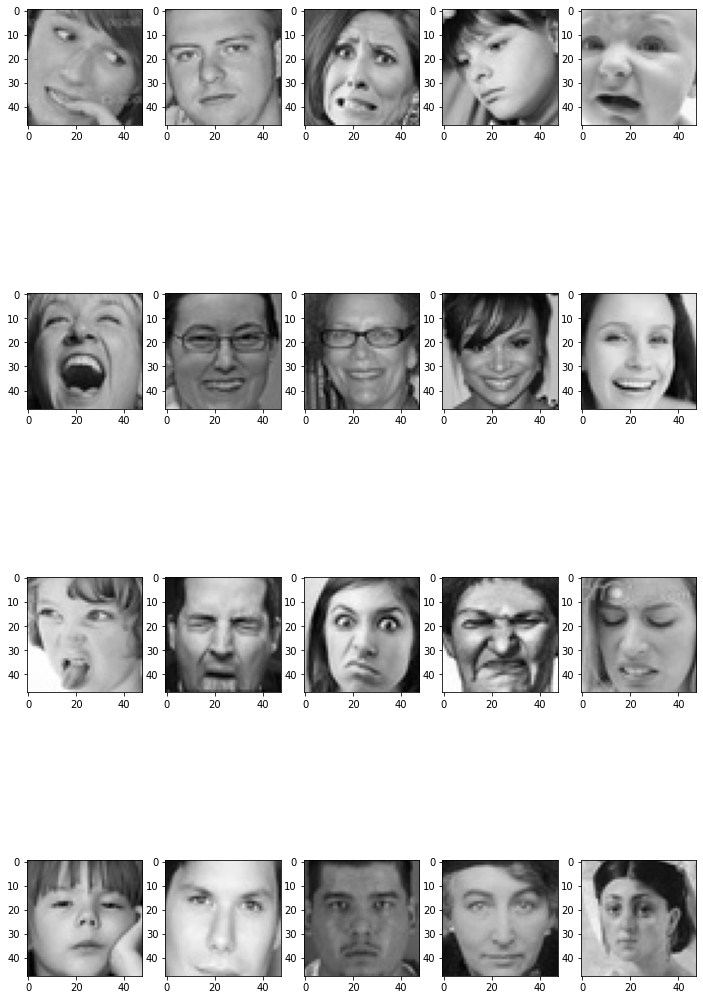

In [6]:
utils.datasets.fer.plot_example_images(plt).show()

In [5]:
for i in ["train","test"]:
    print(i+":")
    for expression in os.listdir("../data/"+i+"/"):
        print(str(len(os.listdir("../data/"+i+"/" + expression))) + " " + expression + " image")

train:
4097 fear image
7215 happy image
436 disgust image
4965 neutral image
3171 surprise image
3995 angry image
4830 sad image
test:
1024 fear image
1774 happy image
111 disgust image
1233 neutral image
831 surprise image
958 angry image
1247 sad image


### Task 3: Generate Training and Validation Batches

In [6]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 40,
    fill_mode = "nearest")

train_generator = datagen_train.flow_from_directory("../data/train/",
                                                   target_size = (img_size,img_size),
                                                   batch_size = batch_size,
                                                   color_mode = "grayscale",
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_test = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 40,
    fill_mode = "nearest")

test_generator = datagen_test.flow_from_directory("../data/test/",
                                                   target_size = (img_size,img_size),
                                                   batch_size = batch_size,
                                                   color_mode = "grayscale",
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [5]:
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(64, (3,3), padding = "same", input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 2nd Convolutional Layer
model.add(Conv2D(128, (5,5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 3rd Convolutional Layer
model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 4th Convolutional Layer
model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(7, activation = "softmax"))
 
opt = Adam(lr = 0.005)


model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Task 6: Train and Evaluate Model

In [7]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = test_generator.n//test_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = "val_accuracy",
                            save_weights_only = True, mode = "max",
                            verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor=0.1, patience=2, min_lr=0.00001,
                             mode="auto")
callbacks = [PlotLossesTensorFlowKeras(), checkpoint, reduce_lr]

history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = test_generator,
    callbacks = callbacks
)

Log-loss (cost function):
training   (min:    1.064, max:    1.880, cur:    1.064)
validation (min:    1.046, max:    2.379, cur:    1.046)

accuracy:
training   (min:    0.264, max:    0.596, cur:    0.596)
validation (min:    0.152, max:    0.601, cur:    0.601)

Epoch 00015: saving model to model_weights.h5
448/448 [==============================] - 32s 72ms/step - loss: 1.0640 - accuracy: 0.5961 - val_loss: 1.0459 - val_accuracy: 0.6007


### Task 7: Represent Model as JSON String

In [8]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)